# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 14, 16, 0, 3, 56220)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1168539
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.2347035E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

RestAPIError: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1168539/featurestores/query). Server response: 
HTTP code: 422, HTTP reason: UNPROCESSABLE_ENTITY, body: b'{"errorCode":120001,"usrMsg":"2024-11-14 16:00:03.056220","errorMsg":"An argument was not provided or it was malformed."}', error code: 120001, error msg: An argument was not provided or it was malformed., user msg: 2024-11-14 16:00:03.056220

### <span style="color:#ff5f27;">🍳 Adding lagged pm25 features</span>

In [ ]:
aq_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

aq_today = aq_fg.filter(aq_fg.date >= yesterday).read()

# sort the data by date
batch_data.sort_values(by="date", inplace=True)
batch_data.reset_index(drop=True, inplace=True)

# Fill tomorrows features with lagged values
batch_data.loc[0, "pm25_lag_1"] = aq_today["pm25"].values[0]
batch_data.loc[0, "pm25_lag_2"] = aq_today["pm25_lag_1"].values[0]
batch_data.loc[0, "pm25_lag_3"] = aq_today["pm25_lag_2"].values[0]

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2024-11-14 00:00:00+00:00,6.00,0.0,15.124284,321.766113,Stockholm,8.0,1.09,7.4
1,2024-11-15 00:00:00+00:00,6.85,0.0,9.470120,261.253906,Stockholm,NaN,NaN,NaN
2,2024-11-16 00:00:00+00:00,10.10,0.0,25.809765,239.858688,Stockholm,NaN,NaN,NaN
3,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,Stockholm,NaN,NaN,NaN
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,Stockholm,NaN,NaN,NaN
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,Stockholm,NaN,NaN,NaN
6,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,Stockholm,NaN,NaN,NaN
7,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,Stockholm,NaN,NaN,NaN
8,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,Stockholm,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
# EDITED: We predict each day in sequence in order to use lagged values
for i in range(len(batch_data)):
    batch_data.loc[i, "predicted_pm25"] = retrieved_xgboost_model.predict(
        batch_data.loc[i:i, ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    
    if i < len(batch_data) - 1:
        batch_data.loc[i+1, "pm25_lag_1"] = batch_data.loc[i, "predicted_pm25"]
        batch_data.loc[i+1, "pm25_lag_2"] = batch_data.loc[i, "pm25_lag_1"]
        batch_data.loc[i+1, "pm25_lag_3"] = batch_data.loc[i, "pm25_lag_2"]


# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2024-11-14 00:00:00+00:00,6.00,0.0,15.124284,321.766113,Stockholm,8.000000,1.090000,7.400000,5.203187
1,2024-11-15 00:00:00+00:00,6.85,0.0,9.470120,261.253906,Stockholm,5.203187,8.000000,1.090000,5.758681
2,2024-11-16 00:00:00+00:00,10.10,0.0,25.809765,239.858688,Stockholm,5.758681,5.203187,8.000000,3.492414
3,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,Stockholm,3.492414,5.758681,5.203187,3.649394
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,Stockholm,3.649394,3.492414,5.758681,2.831274
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,Stockholm,2.831274,3.649394,3.492414,4.006299
6,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,Stockholm,4.006299,2.831274,3.649394,3.107940
7,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,Stockholm,3.107940,4.006299,2.831274,2.835772
8,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,Stockholm,2.835772,3.107940,4.006299,1.737067


In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float64            
 7   pm25_lag_2                   9 non-null      float64            
 8   pm25_lag_3                   9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(3), obj

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [ ]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,6.00,0.0,15.124284,321.766113,Stockholm,8.000000,1.090000,7.400000,5.203187,Söder Mälarstrand,Sweden,1
1,2024-11-15 00:00:00+00:00,6.85,0.0,9.470120,261.253906,Stockholm,5.203187,8.000000,1.090000,5.758681,Söder Mälarstrand,Sweden,2
2,2024-11-16 00:00:00+00:00,10.10,0.0,25.809765,239.858688,Stockholm,5.758681,5.203187,8.000000,3.492414,Söder Mälarstrand,Sweden,3
3,2024-11-17 00:00:00+00:00,5.00,0.6,20.371038,223.567963,Stockholm,3.492414,5.758681,5.203187,3.649394,Söder Mälarstrand,Sweden,4
4,2024-11-18 00:00:00+00:00,4.60,0.0,14.044615,268.531219,Stockholm,3.649394,3.492414,5.758681,2.831274,Söder Mälarstrand,Sweden,5
5,2024-11-19 00:00:00+00:00,1.45,0.0,4.334974,311.633453,Stockholm,2.831274,3.649394,3.492414,4.006299,Söder Mälarstrand,Sweden,6
6,2024-11-20 00:00:00+00:00,3.30,1.4,23.402769,89.118622,Stockholm,4.006299,2.831274,3.649394,3.107940,Söder Mälarstrand,Sweden,7
7,2024-11-21 00:00:00+00:00,6.90,1.1,11.367109,259.045990,Stockholm,3.107940,4.006299,2.831274,2.835772,Söder Mälarstrand,Sweden,8
8,2024-11-22 00:00:00+00:00,1.50,1.8,30.302078,256.954346,Stockholm,2.835772,3.107940,4.006299,1.737067,Söder Mälarstrand,Sweden,9


In [ ]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_lag_1                   9 non-null      float64            
 7   pm25_lag_2                   9 non-null      float64            
 8   pm25_lag_3                   9 non-null      float64            
 9   predicted_pm25               9 non-null      float32            
 10  street                       9 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

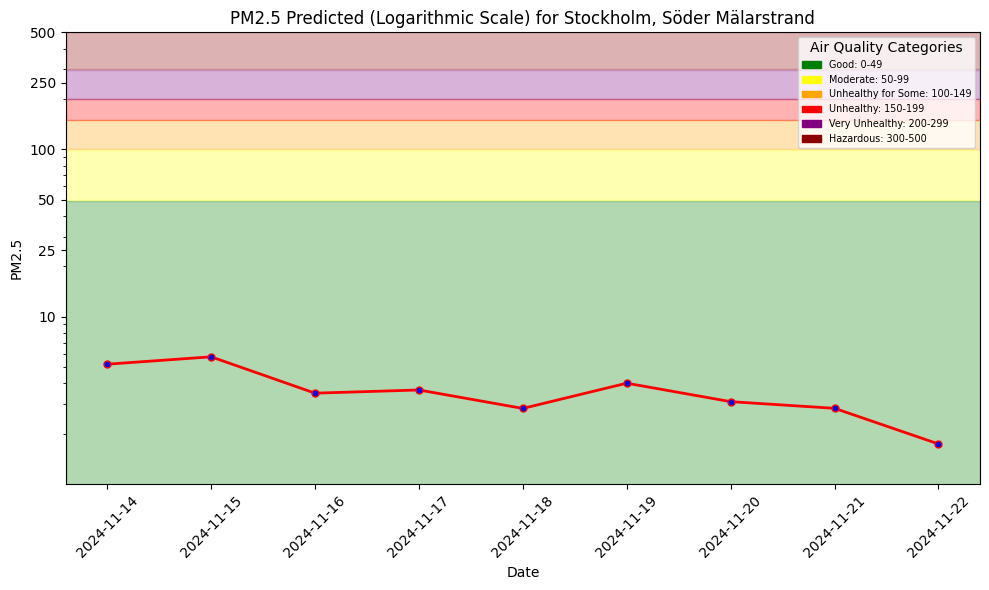

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [ ]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1168539/fs/1159242/fg/1346997


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1168539/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1f176c39c30>, None)

In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-14 00:00:00+00:00,6.0,0.0,15.124284,321.766113,Stockholm,8.0,1.09,7.4,5.203187,Söder Mälarstrand,Sweden,1


In [ ]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.68s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
0,2021-05-26 00:00:00+00:00,1.400000,3.20,3.55,2.23,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1,2024-10-05 00:00:00+00:00,2.000000,2.50,1.90,1.30,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
2,2022-09-24 00:00:00+00:00,2.930000,2.43,1.50,1.20,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
3,2020-12-05 00:00:00+00:00,20.799999,5.85,9.35,8.43,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
4,2023-02-15 00:00:00+00:00,7.500000,1.63,1.20,2.20,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
...,...,...,...,...,...,...,...,...,...
1745,2023-07-11 00:00:00+00:00,2.100000,1.70,2.10,2.69,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1746,2020-07-10 00:00:00+00:00,1.400000,0.70,0.87,0.67,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1747,2023-03-03 00:00:00+00:00,1.200000,1.00,0.90,0.80,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749
1748,2021-07-04 00:00:00+00:00,3.300000,3.50,3.03,2.04,Sweden,Stockholm,Söder Mälarstrand,https://api.waqi.info/feed/A56749


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 


ValueError: feature_names mismatch: ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
expected pm25_lag_2, pm25_lag_1, pm25_lag_3 in input data

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

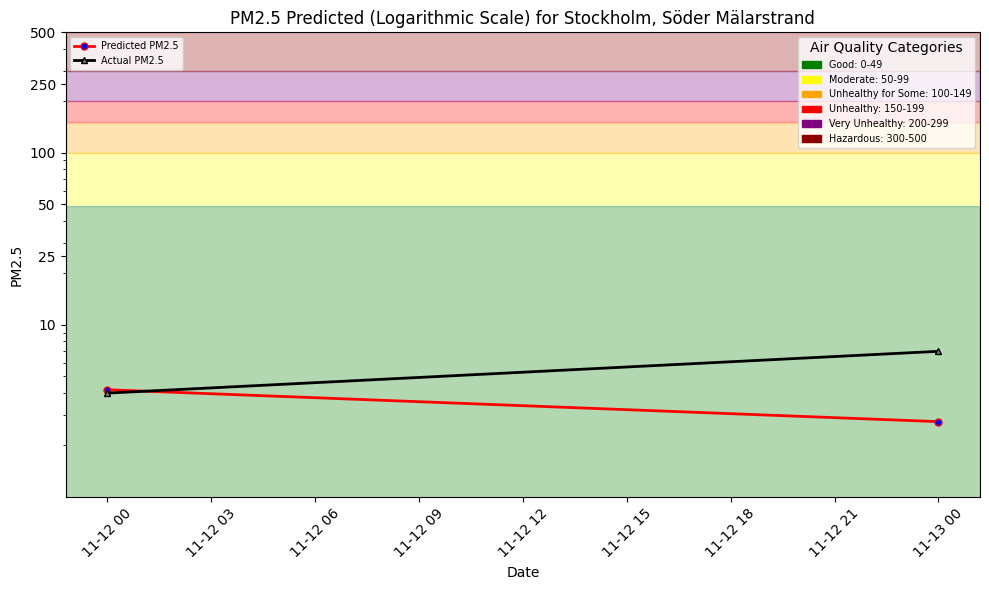

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---